In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [2]:
# Load Data
data = pd.read_csv('TSLA_5year_2018-2022.csv', index_col = 'Date')
data.shape

(1259, 6)

<IPython.core.display.Javascript object>


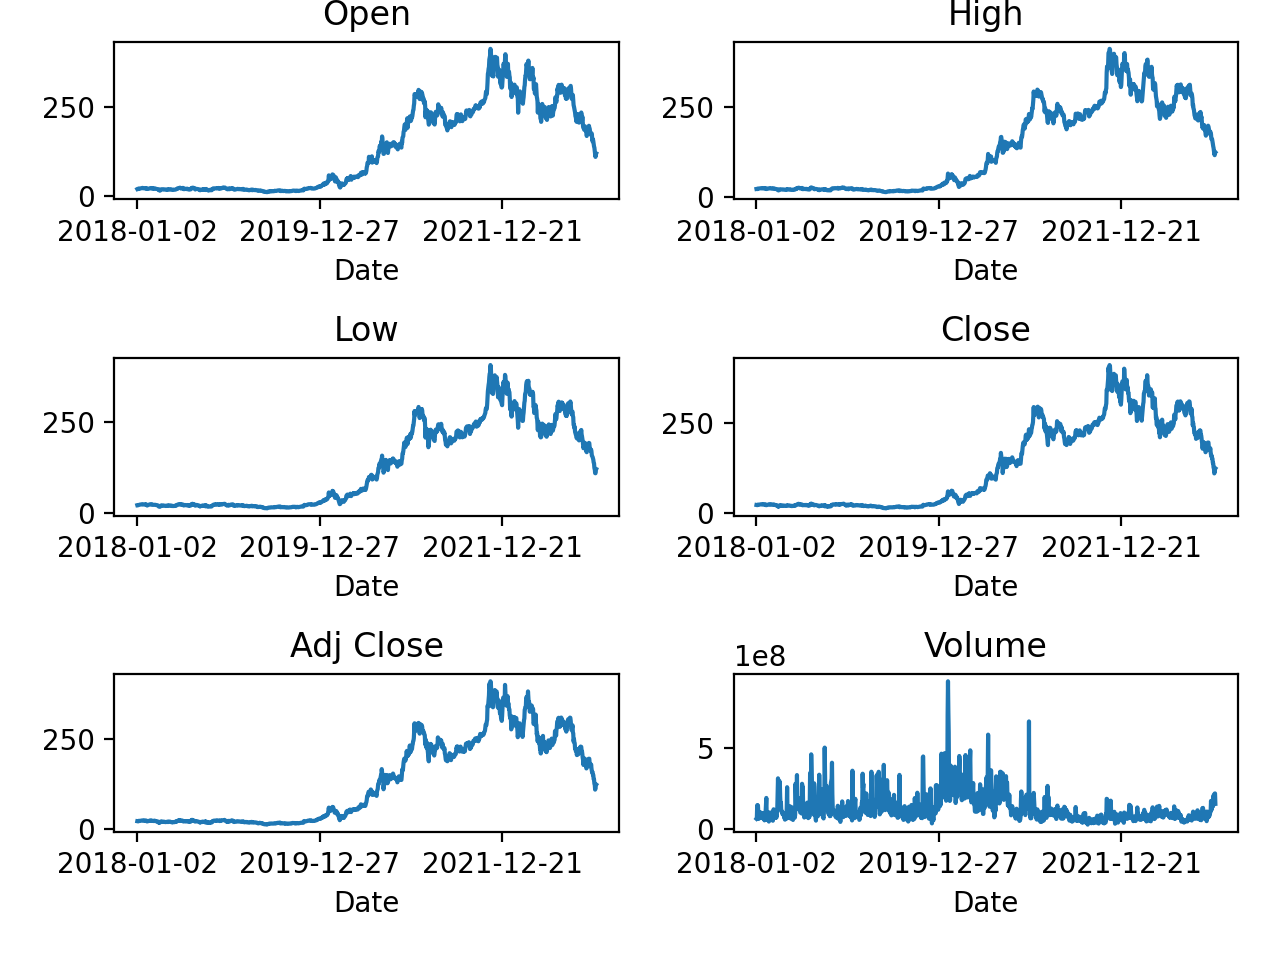

Text(0.5, 1.0, 'Volume')

In [3]:
# Visualize Dataset
%matplotlib notebook

# Create Subplot Figure for all Columns
subplotFig, subplotAx = plt.subplots(3,2, num='Basic Indicator History ($TSLA)')

# Plot All Data Columns (Open,High,Low,Close,Adj Close,& Volume)
data['Open'].plot(ax=subplotAx[0,0])
data['High'].plot(ax=subplotAx[0,1])
data['Low'].plot(ax=subplotAx[1,0])
data['Close'].plot(ax=subplotAx[1,1])
data['Adj Close'].plot(ax=subplotAx[2,0])
data['Volume'].plot(ax=subplotAx[2,1])

# Adjust Figure Layout
plt.tight_layout(pad = 1.5)

# Add Subplot Titles
subplotAx[0,0].set_title("Open")
subplotAx[0,1].set_title("High")
subplotAx[1,0].set_title("Low")
subplotAx[1,1].set_title("Close")
subplotAx[2,0].set_title("Adj Close")
subplotAx[2,1].set_title("Volume")

In [4]:
# Append close to dataframe
data['y'] = data['Close']

# Convert data to numpy array
dataset = data.values

# Get training set size 80:20 split
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

1008

In [5]:
# Scale data for the model
scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(dataset)
scaled_data = dataset

In [6]:
# Create scaled training dataset
train_data = scaled_data[0:training_data_len,:]

# Split to x_train and y_train
x_train = train_data[:,:6]
y_train = train_data[:,6]

# Create scaled test dataset
test_data = scaled_data[training_data_len:,:]

# Split to x_test and y_test
x_test = test_data[:,:6]
y_test = test_data[:,6]

# Show shapes of sets
print('x_train shape: ' + str(x_train.shape))
print('y_train shape: ' + str(y_train.shape))
print()
print('x_test shape: ' + str(x_test.shape))
print('y_test shape: ' + str(y_test.shape))

x_train shape: (1008, 6)
y_train shape: (1008,)

x_test shape: (251, 6)
y_test shape: (251,)


In [7]:
# Convert training and testing sets to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Scale data
scaled_data = scaler.fit_transform(dataset)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train.reshape(-1,1))
x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test.reshape(-1,1))

x_train

array([[0.02184962, 0.02245651, 0.02268277, 0.02370959, 0.02370959,
        0.04055838],
       [0.02335189, 0.02297716, 0.02345291, 0.02316023, 0.02316023,
        0.04342891],
       [0.02199484, 0.0218662 , 0.0217823 , 0.02271974, 0.02271974,
        0.13540791],
       ...,
       [0.88668738, 0.8843514 , 0.87063324, 0.87964316, 0.87964316,
        0.0302394 ],
       [0.8555488 , 0.87734563, 0.86133232, 0.86636976, 0.86636976,
        0.01993839],
       [0.86565567, 0.86611158, 0.86255103, 0.85501411, 0.85501411,
        0.01280904]])

In [11]:
train_x = x_train
train_y = y_train
test_x = x_test
test_y = y_test

# Code below modified from: https://github.com/ChickenBenny/Stock-prediction-with-GAN-and-WGAN/blob/main/wgan-gp_demo.ipynb

In [12]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan
     
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, y_train, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, y_test, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([1005, 3, 6]) train_y: torch.Size([1005, 1]) train_y_gan: torch.Size([1005, 4, 1])
test_x: torch.Size([248, 3, 6]) test_y: torch.Size([248, 1]) test_y_gan: torch.Size([248, 4, 1])


In [74]:
# Build Generator: Gated Recurrent Unit Network
# Note: Using GRU for testing purposes only. LSTM will be used here in the final architecture
# TODO: Implement LSTM
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out_6 = self.linear_3(out_5)
        return out_6

# Build Discriminator: Convolutional Neural Network Version 3.2
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1-Dimensional Convolutional Layers with LeakyReLU and Batch Normalization
        self.conv_layer0 = nn.Conv1d(4, 32, kernel_size=5, stride=1, padding='same')
        self.conv_layer1 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding='same')
        self.leakyrelu_layer2 = nn.LeakyReLU(0.01)
        self.conv_layer3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding='same')
        self.leakyrelu_layer4 = nn.LeakyReLU(0.01)
        self.batchnorm_layer5 = nn.BatchNorm1d(128)
        self.conv_layer6 = nn.Conv1d(128, 220, kernel_size=5, stride=1, padding='same')
        self.leakyrelu_layer7 = nn.LeakyReLU(0.01)
        self.batchnorm_layer8 = nn.BatchNorm1d(220)
        
        # Fully Connected Layers
        self.dense_layer9 = nn.Linear(220, 220, bias=False)
        self.batchnorm_layer10 = nn.BatchNorm1d(220)
        self.leakyrelu_layer11 = nn.LeakyReLU(0.01)
        self.dense_layer12 = nn.Linear(220, 220, bias=False)
        self.activation_layer13 = nn.ReLU()
        self.dense_layer14 = nn.Linear(220, 1)
        

    def forward(self, x):
        conv_layer0 = self.conv_layer0(x)
        conv_layer1 = self.conv_layer1(conv_layer0)
        leakyrelu_layer2 = self.leakyrelu_layer2(conv_layer1)
        conv_layer3 = self.conv_layer3(leakyrelu_layer2)
        leakyrelu_layer4 = self.leakyrelu_layer4(conv_layer3)
        batchnorm_layer5 = self.batchnorm_layer5(leakyrelu_layer4)
        conv_layer6 = self.conv_layer6(batchnorm_layer5)
        leakyrelu_layer7 = self.leakyrelu_layer7(conv_layer6)
        batchnorm_layer8 = self.batchnorm_layer8(leakyrelu_layer7)
        reshape =  batchnorm_layer8.reshape(batchnorm_layer8.shape[0], batchnorm_layer8.shape[1])
        dense_layer9 = self.dense_layer9(reshape)
        batchnorm_layer10 = self.batchnorm_layer10(dense_layer9)
        leakyrelu_layer11 = self.leakyrelu_layer11(batchnorm_layer10)
        dense_layer12 = self.dense_layer12(leakyrelu_layer11)
        activation_layer13 = self.activation_layer13(dense_layer12)
        dense_layer14 = self.dense_layer14(activation_layer13)
        return dense_layer14

In [89]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000115
num_epochs = 250
critic_iterations = 10
weight_clip = 0.01

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(6).to(device)
modelD = Discriminator().to(device)

optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        critic_real = modelD(y)
        critic_fake = modelD(fake_data)
        lossD = -(torch.mean(critic_real) - torch.mean(critic_fake))
        modelD.zero_grad()
        lossD.backward(retain_graph = True)
        optimizerD.step()

        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()

        loss_D.append(lossD.item())
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/250] LossD: -0.3092489782720804 LossG:0.262002925388515
[2/250] LossD: -1.3164541721343994 LossG:0.730512535199523
[3/250] LossD: -2.2708370834589005 LossG:1.2559459060430527
[4/250] LossD: -3.180166870355606 LossG:1.7586364224553108
[5/250] LossD: -4.143144369125366 LossG:2.4455084800720215
[6/250] LossD: -3.667935937643051 LossG:1.9934631511569023
[7/250] LossD: -2.666893556714058 LossG:0.9664782066829503
[8/250] LossD: -3.2993039339780807 LossG:1.43596430728212
[9/250] LossD: -3.7438807040452957 LossG:1.963603151962161
[10/250] LossD: -4.206217721104622 LossG:2.464447546750307
[11/250] LossD: -4.572615817189217 LossG:3.1718371585011482
[12/250] LossD: -4.853693753480911 LossG:3.6763696372509003
[13/250] LossD: -5.550549536943436 LossG:4.9055966436862946
[14/250] LossD: -5.59955969452858 LossG:5.26229253411293
[15/250] LossD: -6.1562522649765015 LossG:6.4074137806892395
[16/250] LossD: -6.580297082662582 LossG:7.101337552070618
[17/250] LossD: -7.150175988674164 LossG:8.5862187743

[138/250] LossD: -147.23918628692627 LossG:185.7131052017212
[139/250] LossD: -160.78404998779297 LossG:261.9154472351074
[140/250] LossD: -220.60022926330566 LossG:273.63698959350586
[141/250] LossD: -295.96363639831543 LossG:263.7673053741455
[142/250] LossD: -113.68025350570679 LossG:202.3647837638855
[143/250] LossD: -226.9063491821289 LossG:290.4829194545746
[144/250] LossD: -111.53450870513916 LossG:206.5439682006836
[145/250] LossD: -244.49906730651855 LossG:244.3071632385254
[146/250] LossD: -218.01952981948853 LossG:300.54743099212646
[147/250] LossD: -280.79150390625 LossG:296.40512931346893
[148/250] LossD: -104.13999080657959 LossG:185.72980451583862
[149/250] LossD: -149.64961004257202 LossG:312.76820373535156
[150/250] LossD: -203.5967025756836 LossG:326.90428256988525
[151/250] LossD: -208.47810745239258 LossG:323.56996726989746
[152/250] LossD: -207.3546962738037 LossG:244.99548482894897
[153/250] LossD: -264.5682487487793 LossG:385.3536567687988
[154/250] LossD: -199.2

<IPython.core.display.Javascript object>


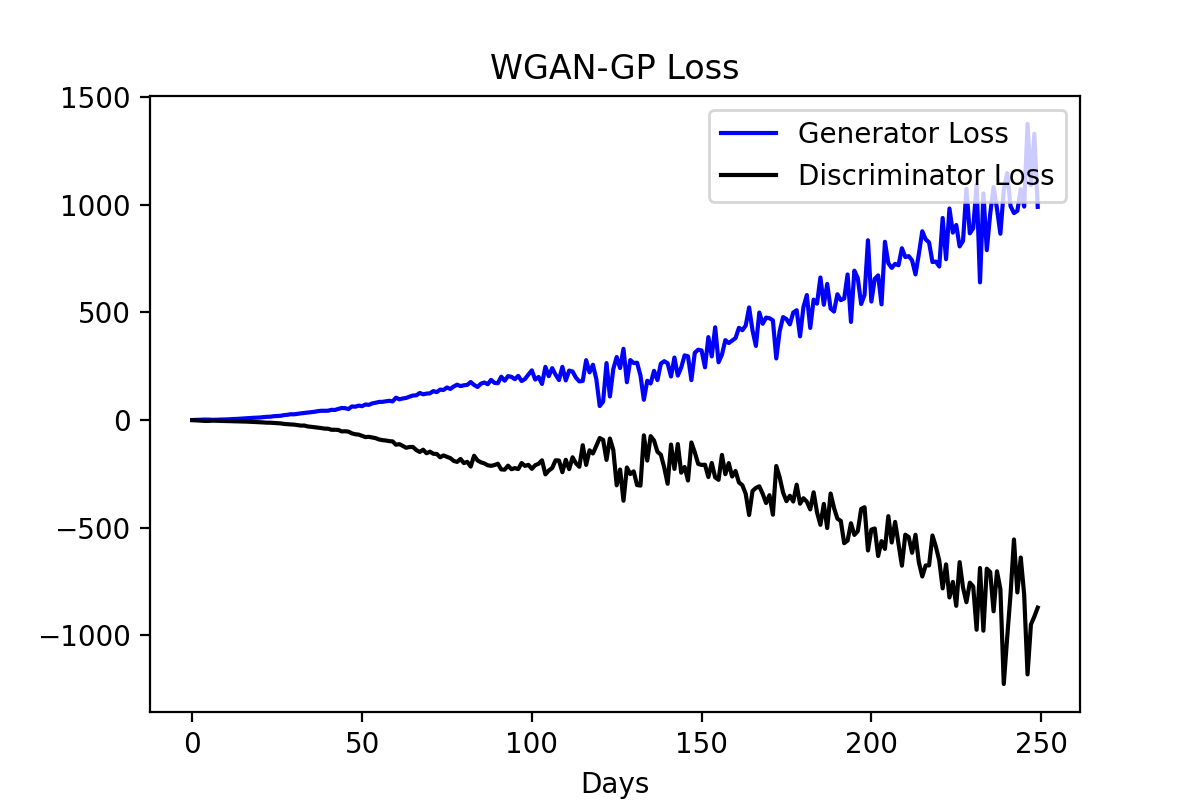

In [96]:
plt.figure(figsize = (6, 4))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('WGAN-GP Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [91]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = scaler.inverse_transform(train_y_slide)
y_train_pred = scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = scaler.inverse_transform(test_y_slide)
y_test_pred = scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

<IPython.core.display.Javascript object>


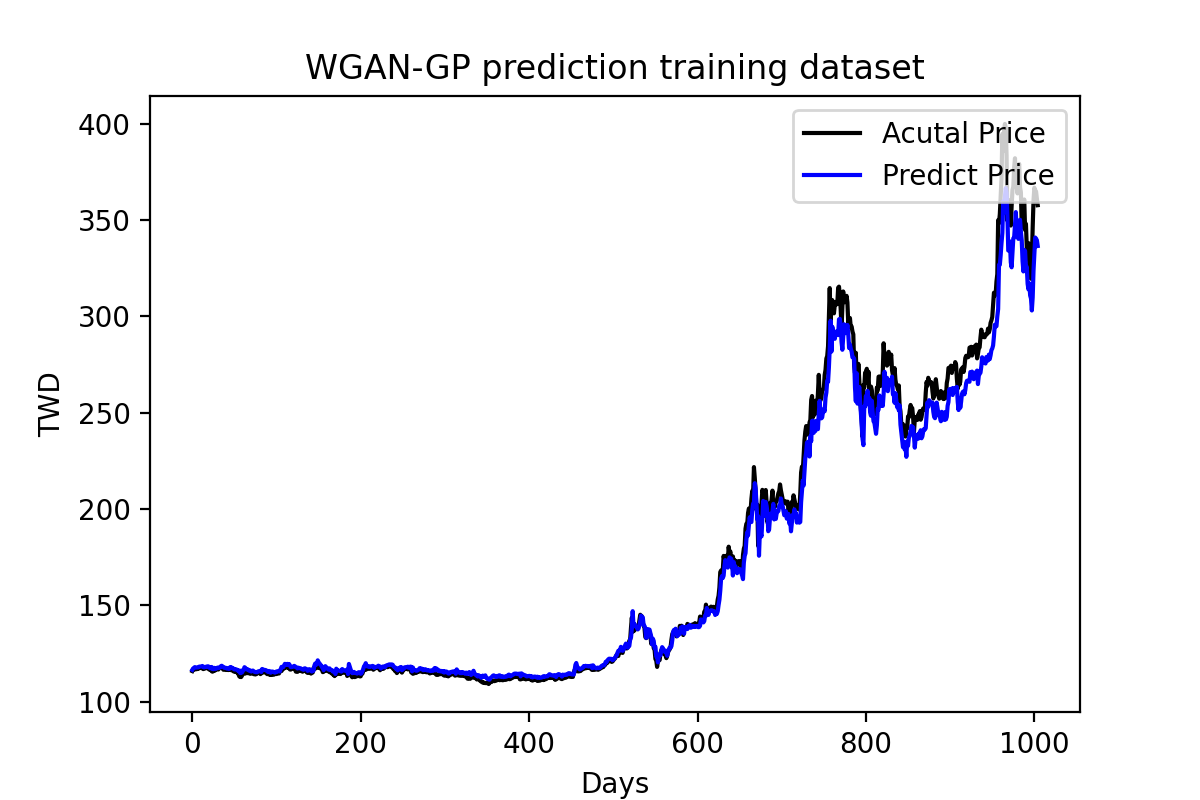

Training dataset RMSE:9.2138110312711


In [94]:

plt.figure(figsize=(6, 4))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

<IPython.core.display.Javascript object>


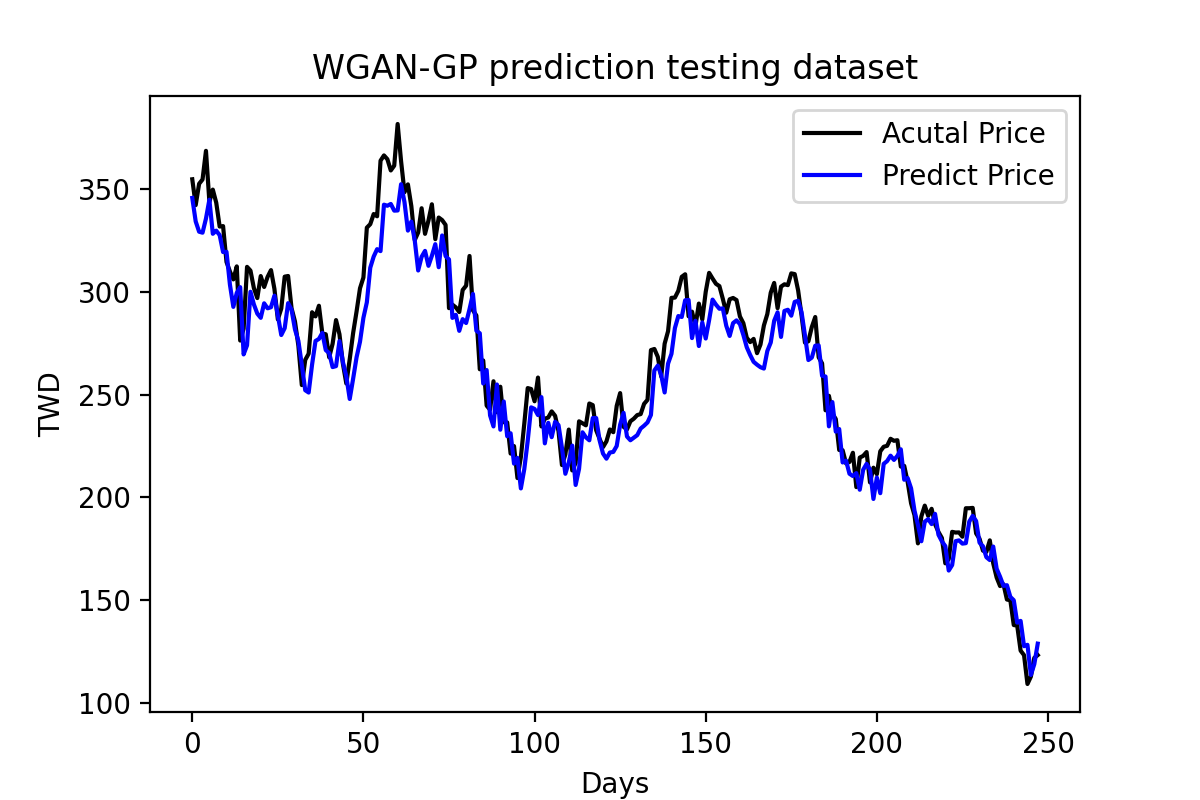

Training dataset RMSE:14.16221941247053


In [95]:

plt.figure(figsize=(6, 4))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')